In [25]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [26]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [28]:
# create engine to hawaii.sqlite
Base = automap_base()
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [29]:
# reflect an existing database into a new model

# reflect the tables

Base.prepare(autoload_with=engine)


In [30]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [31]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [32]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [33]:
# Inspect the database

# Set up inspector

inspector = inspect(engine)


In [34]:
# Inspect the station table

columns_station = inspector.get_columns('station')

for column in columns_station:
    print(column["name"], column["type"])



id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [35]:
# Inspect the measurement table

columns_measurement = inspector.get_columns('measurement')

for column in columns_measurement:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [36]:
# Find the most recent date in the data set. ('2017-08-23',)

recent_date = session.query(func.max(Measurement.date)).first()
print(recent_date)

('2017-08-23',)


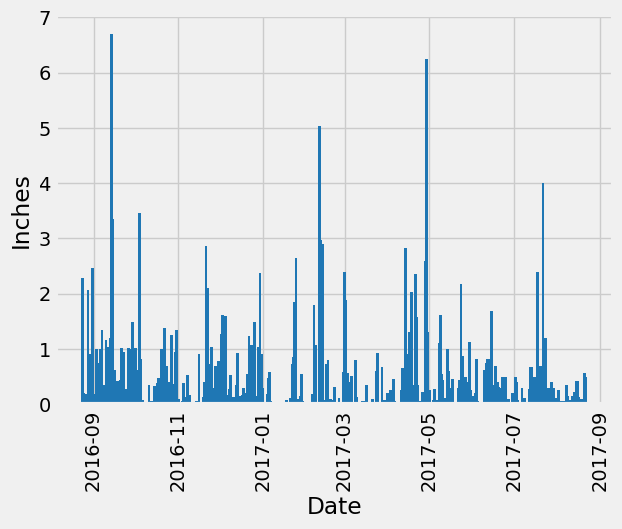

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

recent_date=str(recent_date).\
    replace(',', '').\
    replace('(', '').\
    replace(')', '').\
    replace("'", '')
    
recent_date = dt.strptime(recent_date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.

previous_year = recent_date - relativedelta(years=1)

# Perform a query to retrieve the date and precipitation scores

recent_precip = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date < recent_date).\
                    filter(Measurement.date > previous_year).all()
                    
# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.read_sql_query(sql = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date < recent_date).\
                    filter(Measurement.date > previous_year).statement, con = engine)

df=df.rename(columns={'date':'date', 'prcp': 'precipitation'})

# Sort the dataframe by date

df=df.sort_values(by=["date"])

# Use Pandas Plotting with Matplotlib to plot the data

df['date']= pd.to_datetime(df['date'])

plt.bar(df.date, df.precipitation, color='tab:blue', width = 2, align="center")

plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Inches")

plt.show()


In [38]:
# Use Pandas to calculate the summary statistics for the precipitation data
df['precipitation'].describe()

count    2011.000000
mean        0.176549
std         0.460667
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [39]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).count()
print(station_count)

9


In [40]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

active_station = session.query(Measurement.station, func.count(Measurement.prcp)).\
                            group_by(Measurement.station).\
                            order_by(func.count(Measurement.prcp).desc()).\
                            all()

print(active_station)


[('USC00519281', 2772), ('USC00513117', 2696), ('USC00519397', 2685), ('USC00519523', 2572), ('USC00516128', 2484), ('USC00514830', 1937), ('USC00511918', 1932), ('USC00517948', 683), ('USC00518838', 342)]


In [41]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# [(54.0, 85.0, 71.66378066378067)]

most_active_id = active_station[0]
most_active_id = most_active_id[0]


temps_most_active = session.query(func.min(Measurement.tobs),
                func.max(Measurement.tobs),
                func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active_id).all()

print(temps_most_active)

[(54.0, 85.0, 71.66378066378067)]


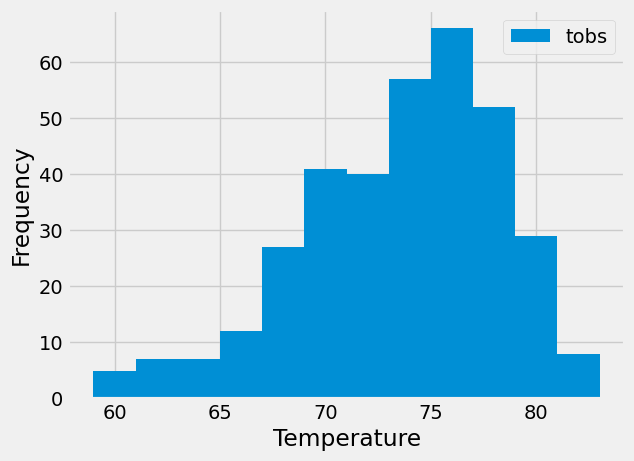

In [42]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


df = pd.read_sql_query(sql = session.query(Measurement.tobs).\
                filter(Measurement.station == most_active_id).\
                filter(Measurement.date < recent_date).\
                filter(Measurement.date > previous_year).statement, con = engine)

df.hist(legend=True, bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.title('')
plt.show()

# Close Session

In [43]:
# Close Session
session.close()